In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# from dotenv import load_dotenv
# load_dotenv('.env')

# import os
# token = os.getenv("GITHUB_TOKEN")
# username = 'alessandroardenghi'
# repo = 'SemanticSegmentation'

# Data Preparation and Exploration

We are given a dataset containing 15048 GeoTIFF files which contain an RGB image, the corresponding infrared image, the elevation map and a label map that gives each pixel a label from the following classes: <br>
- Impervious surface
- Building
- Low Vegetation
- Tree
- Car
- Clutter/Background 

Our task will be to train some semantic segmentation models that will be able to accurately predict pixel-level labels.

In [19]:
import random
import tensorflow as tf
import os
import math
import tensorflow as tf
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from utils import read_tiff, plot_tiff, serialize_datapoint, parse_rgb_ir, plot_history, plot_inference_results
from models import build_base_model, build_shallow_unet
from tensorflow.keras.callbacks import ModelCheckpoint


## Data Selection

In this very brief subsection we analyse the original dataset, select a subset of 5000 images to train, validate and test our models and build 5 folds to perform 5-fold cross validation. 

In [2]:
random.seed(1)

datapoints = [f'data/{element}' for element in os.listdir('data') if element.endswith('.tif')]
print(f'Example Datapoints:\n{datapoints[:3]}\n')
print(f'# of Datapoints: {len(datapoints)}')

n_elements = 5000
selected_datapoints = random.sample(datapoints, n_elements)
random.shuffle(selected_datapoints)
print(f'# of randomly selected Datapoints: {len(selected_datapoints)}\n')

n_folds = 5
fold_size = n_elements // n_folds
folds = [selected_datapoints[i*fold_size: (i+1)*fold_size] for i in range(n_folds)]

# Sanity Check
for i, fold in enumerate(folds):
  print(f'n_datapoints in fold {i} = {len(fold)}')

Example Datapoints:
['data/0000030240-0000043232.tif', 'data/0000016800-0000032256.tif', 'data/0000032704-0000021280.tif']

# of Datapoints: 15048
# of randomly selected Datapoints: 5000

n_datapoints in fold 0 = 1000
n_datapoints in fold 1 = 1000
n_datapoints in fold 2 = 1000
n_datapoints in fold 3 = 1000
n_datapoints in fold 4 = 1000


Here we plot a few of the .tiff images both in RGB, infrared, elevation and segmentation mask.

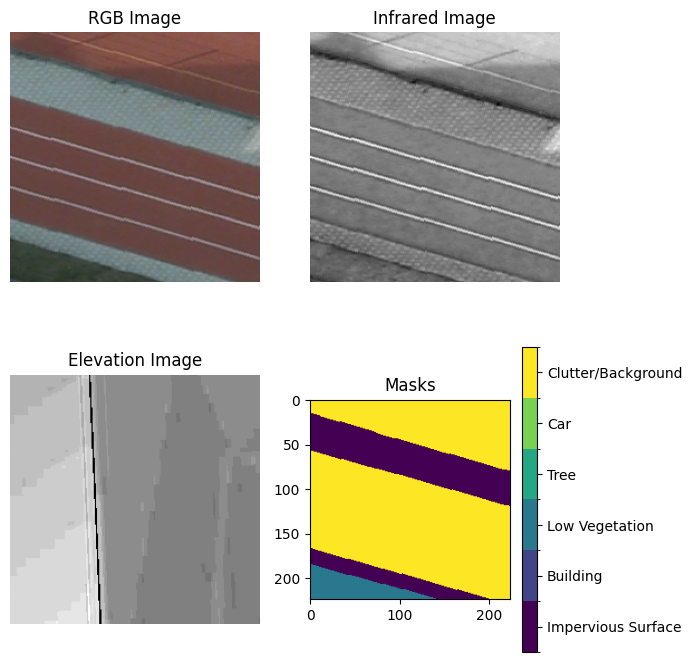

In [3]:
plot_tiff(folds[0][1], figsize=(7, 7))

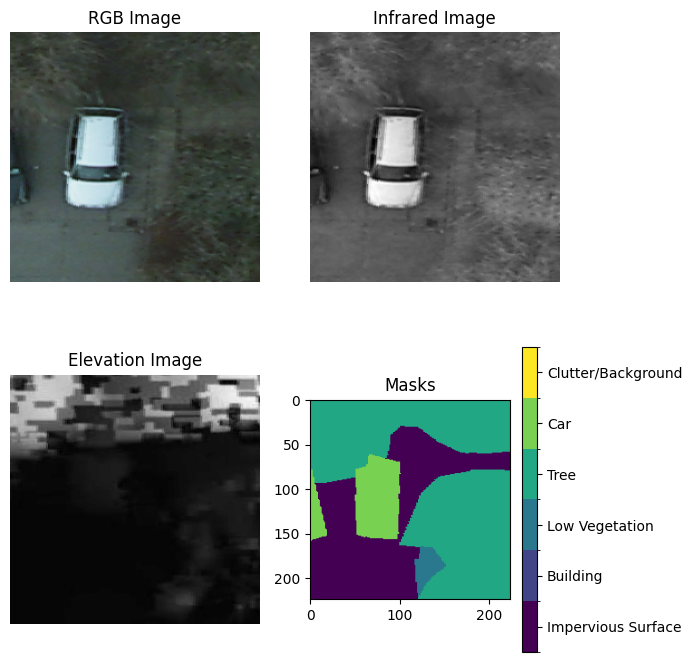

In [4]:
plot_tiff(folds[4][3], figsize=(7, 7))

Next, we build the TFRecord files that will be used during training

In [17]:
from tqdm import tqdm
pbar = tqdm(total=5000)
for i, fold in enumerate(folds):
  with tf.io.TFRecordWriter(f"TFRecord_dir/TFRecord_fold{i}.tfrecord") as writer:
    for datapoint in fold:
        serialized_datapoint = serialize_datapoint(datapoint)
        writer.write(serialized_datapoint)
        pbar.update(1)
pbar.close()

100%|██████████| 5000/5000 [00:47<00:00, 105.57it/s]


# Model Training

### Simple Convolutional Model

We start our analysis by implementing a simple convolutional model with just 2 convolutional layers with kernels of size (3, 3) and 32 and 6 channels respectively.

In [5]:
base_model = build_base_model((224, 224, 4))
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 6)    │         1,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

We will use the first 3 folds to train, the 4th fold to validate and the 5th fold to test the model. We choose a batch size of 16 and we build the functions _parse\_datapoint_ and _parse\_rgb\_ir_ that respectively parse a datapoint from a TFRecord file and return only its first 4 channels (i.e. RGB + Infrared) and the corresponding labels. <br>
Therefore in this instance we do not exploit the elevation information.

In [ ]:
train_filenames = [
    "TFRecord_dir/TFRecord_fold0.tfrecord",
    "TFRecord_dir/TFRecord_fold1.tfrecord",
    "TFRecord_dir/TFRecord_fold2.tfrecord"
]
eval_filenames = [
    "TFRecord_dir/TFRecord_fold3.tfrecord"]

test_filenames = [
    "TFRecord_dir/TFRecord_fold4.tfrecord"]

batch_size = 16

epochs = 20

To build the train dataset we use the .map function to apply the parse_rgb_ir function (which again returns the RGB image and Infrared Image + corresponding label) to the whole training TFRecord file. <br>
We choose 100 as buffer_size to limit the use of RAM and we choose a batch size of 16. <br>
The number of epochs is 20 because we do not have enough computational power to perform a longer training.

In [ ]:
train_dataset = (
    tf.data.TFRecordDataset(train_filenames)
    .map(parse_rgb_ir, num_parallel_calls=4)      
    .shuffle(buffer_size=100)                   
    .batch(batch_size)
    .prefetch(1)                                
)

eval_dataset = (
    tf.data.TFRecordDataset(eval_filenames)
    .map(parse_rgb_ir, num_parallel_calls=4)
    .batch(batch_size)
    .prefetch(1)
)

test_dataset = (
    tf.data.TFRecordDataset(test_filenames)
    .map(parse_rgb_ir, num_parallel_calls=4)
    .batch(batch_size)  # Use the same batch size as during training.
    .prefetch(1)
)

checkpoint_callback = ModelCheckpoint(
    filepath='best_base_model.keras',  
    monitor='val_loss',           
    save_best_only=True,          
    mode='min',                   
    verbose=1    
)

steps_per_epoch = 3000 // batch_size 
history = base_model.fit(train_dataset,
                        epochs=epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=eval_dataset, 
                        callbacks = [checkpoint])

We performed the training on Colab with a T4 GPU and obtained the following trained model and the following history.

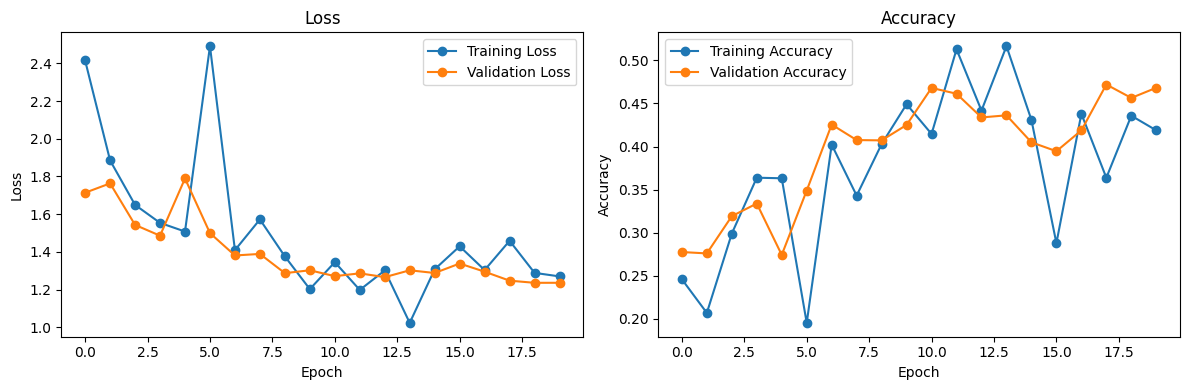

In [12]:
base_model = tf.keras.models.load_model('saved_models/base_model.keras')
base_history = plot_history('saved_models/base_model_history.json')

In [13]:
print(f'Best Validation Accuracy: {np.max(base_history["val_accuracy"]):.3f}\nFinal Validation Accuracy: {base_history["val_accuracy"][-1]:.3f}')

Best Validation Accuracy: 0.472
Final Validation Accuracy: 0.468


Next, we evaluate the model performance on the test set.

In [18]:
test_loss, test_accuracy = base_model.evaluate(test_dataset, steps=1000//batch_size)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.4706 - loss: 1.2250
Test Loss: 1.224
Test Accuracy: 0.478


We now plot some of the inference results against their ground truths

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


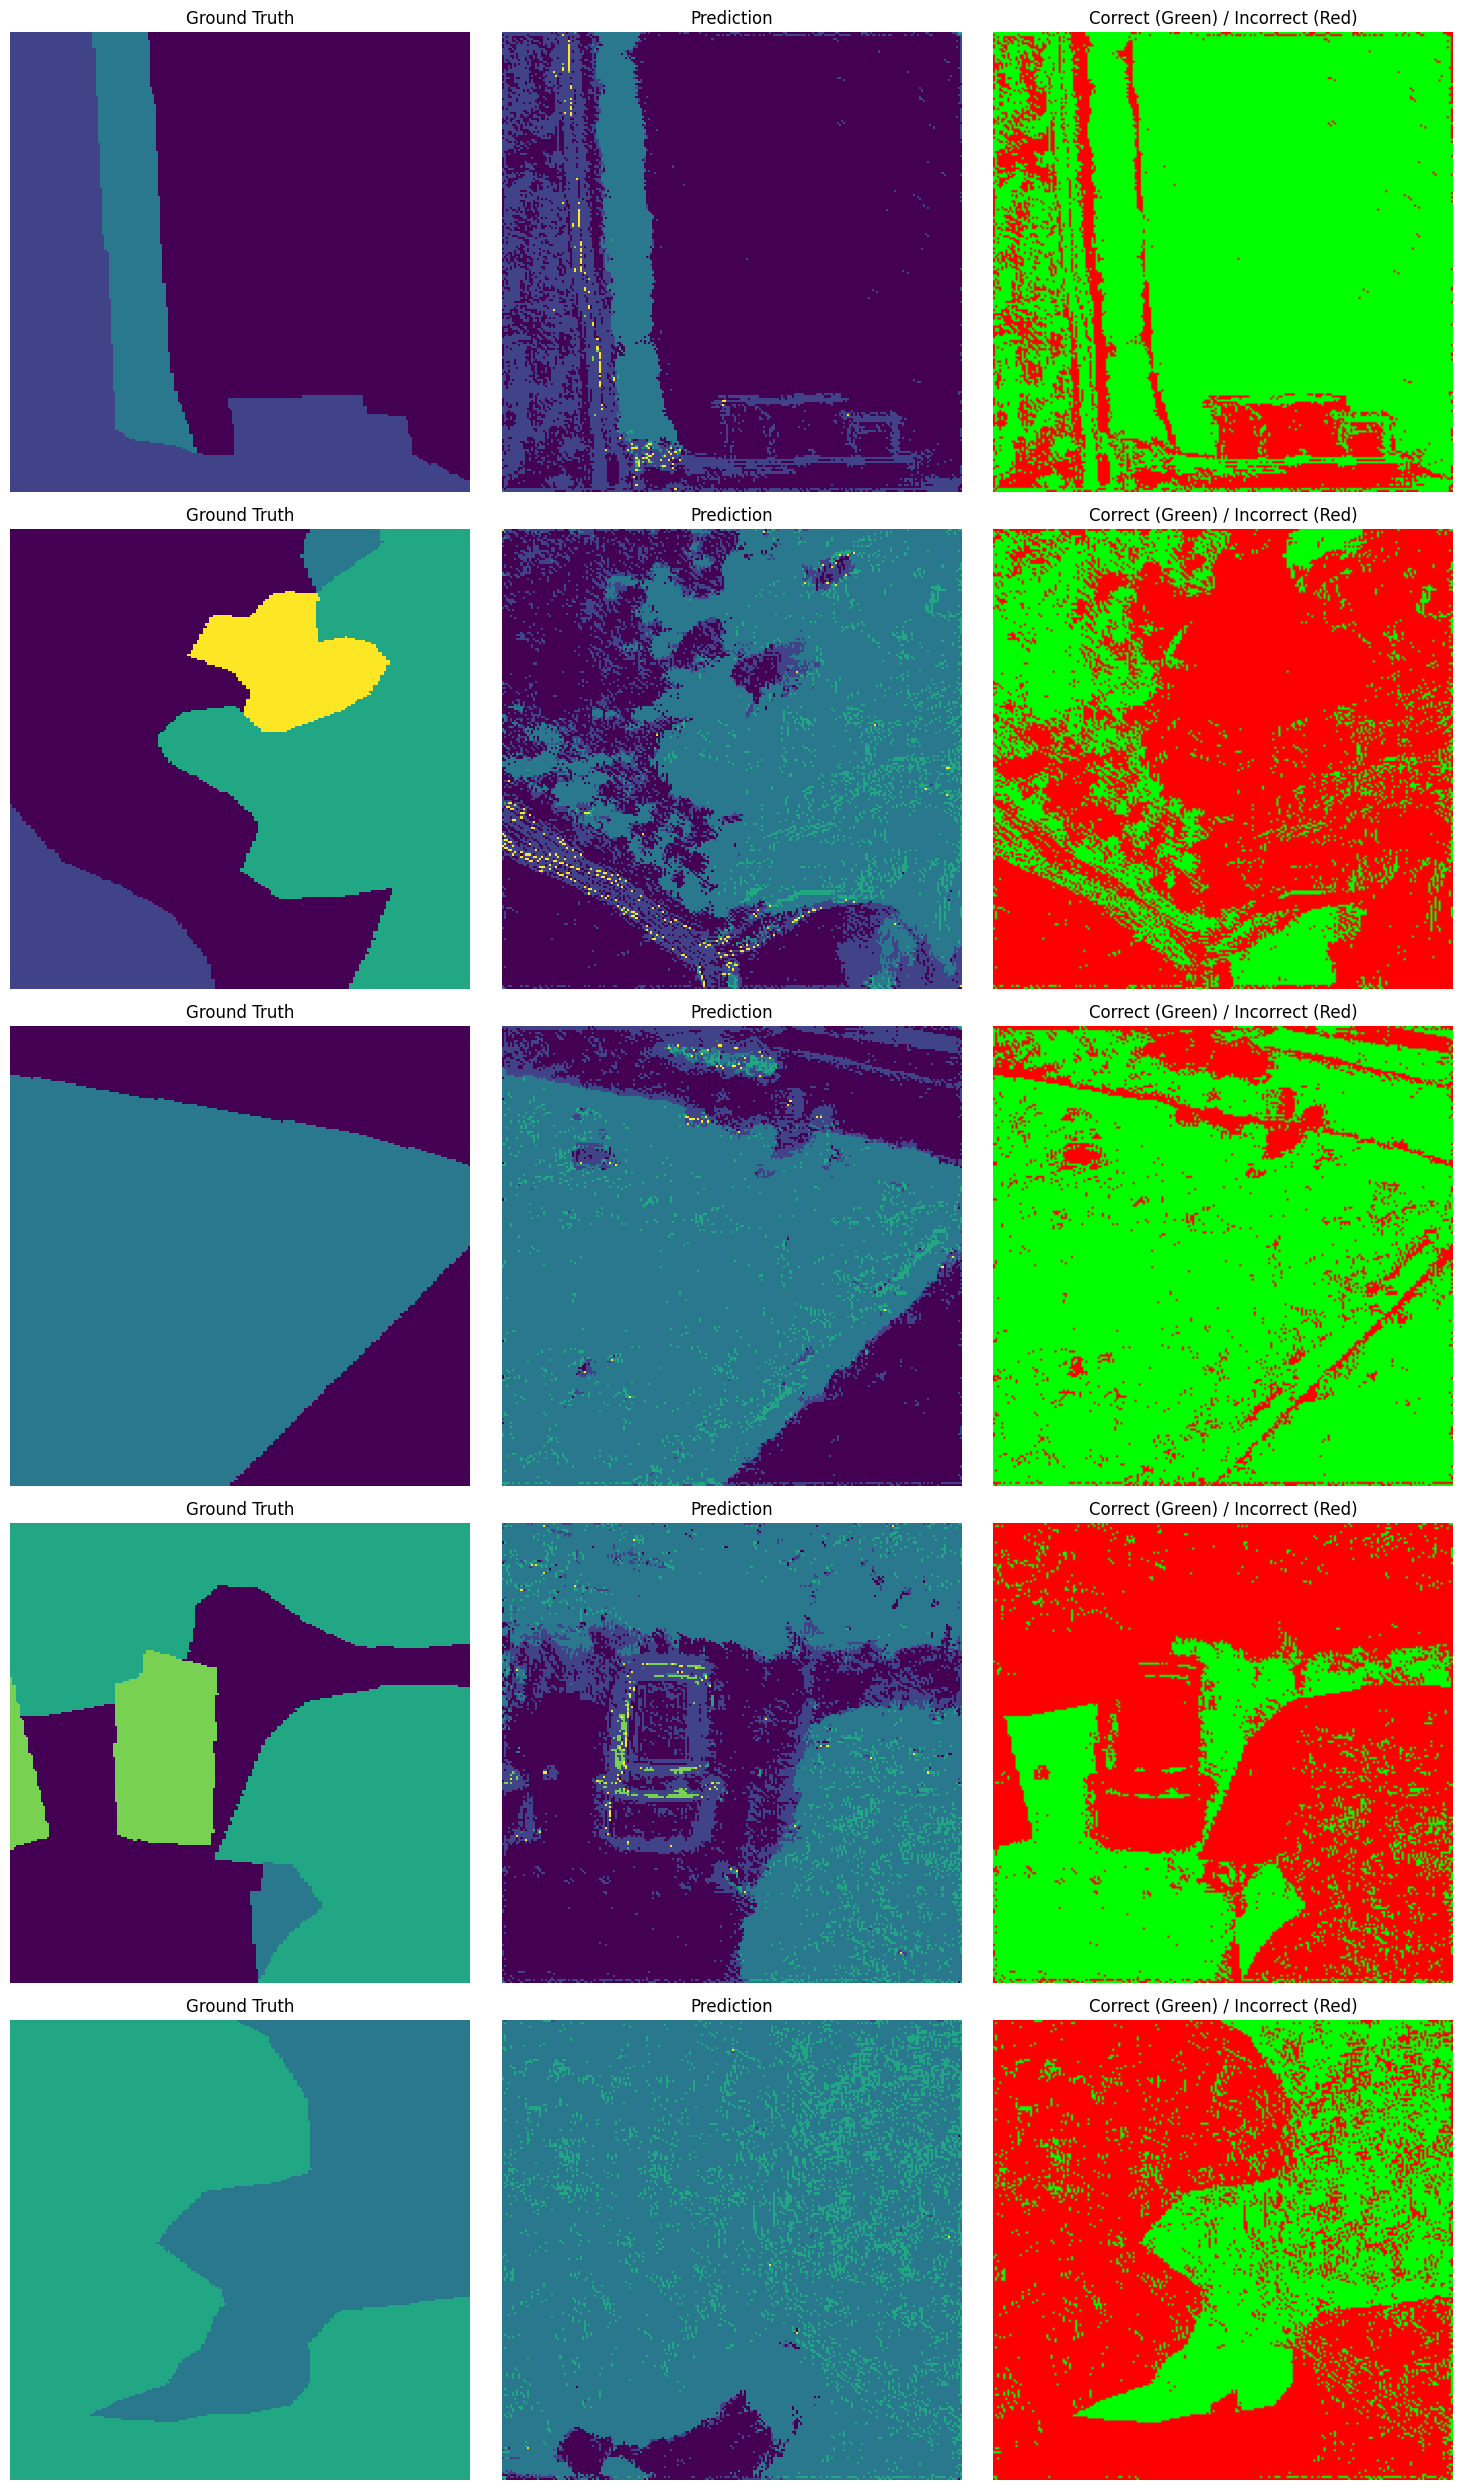

In [20]:
plot_inference_results(test_dataset, base_model, 5)

As we can see, the model is able to detect some structure, but is very imprecise and consistently mislabels the pixels.

In [49]:
train_filenames = [
    "TFRecord_dir/TFRecord_fold0.tfrecord",
    "TFRecord_dir/TFRecord_fold1.tfrecord",
    "TFRecord_dir/TFRecord_fold2.tfrecord"
]
eval_filenames = [
    "TFRecord_dir/TFRecord_fold3.tfrecord"]

batch_size = 32
train_dataset = (
    tf.data.TFRecordDataset(train_filenames)
    .map(parse_rgb, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Create the evaluation dataset.
eval_dataset = (
    tf.data.TFRecordDataset(eval_filenames)
    .map(parse_rgb_ir, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

epochs = 20
steps_per_epoch = 3000 // 32  # Adjust if not perfectly divisible
history = model.fit(train_dataset, 
                    epochs=epochs, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data=eval_dataset)

Epoch 1/20
 5/93 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.2395 - loss: 2.7978

KeyboardInterrupt: 

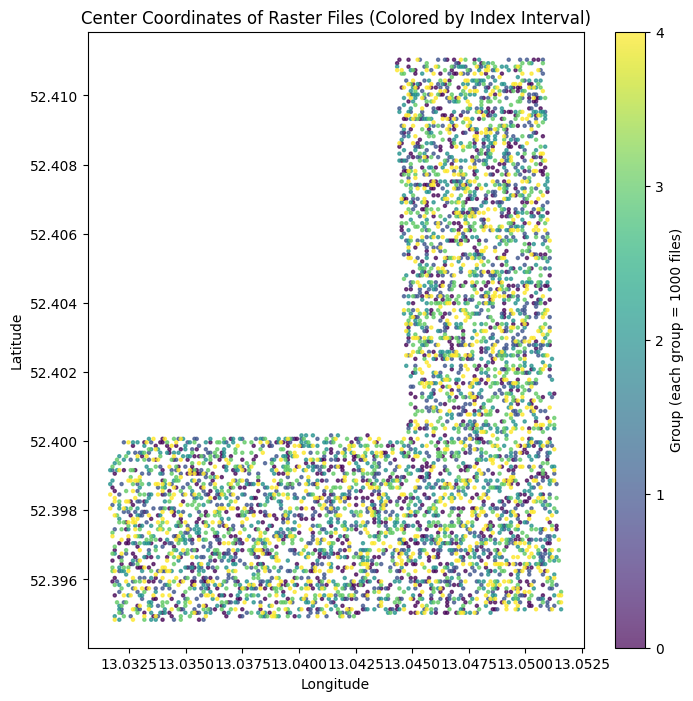

In [70]:
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.transform import xy
import numpy as np

# List of your raster file paths (replace with your actual list of 5000 files)
raster_files = selected_datapoints

lons = []
lats = []
groups = []  # This will hold group numbers based on index intervals

for i, file in enumerate(raster_files):
    with rio.open(file) as dataset:
        width, height = dataset.width, dataset.height
        center_x = width // 2
        center_y = height // 2
        lon, lat = xy(dataset.transform, center_y, center_x)
        lons.append(lon)
        lats.append(lat)
        # Determine the group based on the file's index
        groups.append(i // 1000)  # Group 0: indices 0-999, Group 1: 1000-1999, etc.

# Convert lists to numpy arrays (optional, but useful)
lons = np.array(lons)
lats = np.array(lats)
groups = np.array(groups)

# Create the plot using a colormap. Here 'viridis' is used, but you can choose any colormap.
plt.figure(figsize=(8, 8))
scatter = plt.scatter(lons, lats, c=groups, cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Center Coordinates of Raster Files (Colored by Index Interval)')
# Add a colorbar to indicate the groups
cbar = plt.colorbar(scatter, ticks=range(groups.max()+1))
cbar.set_label('Group (each group = 1000 files)')
plt.show()



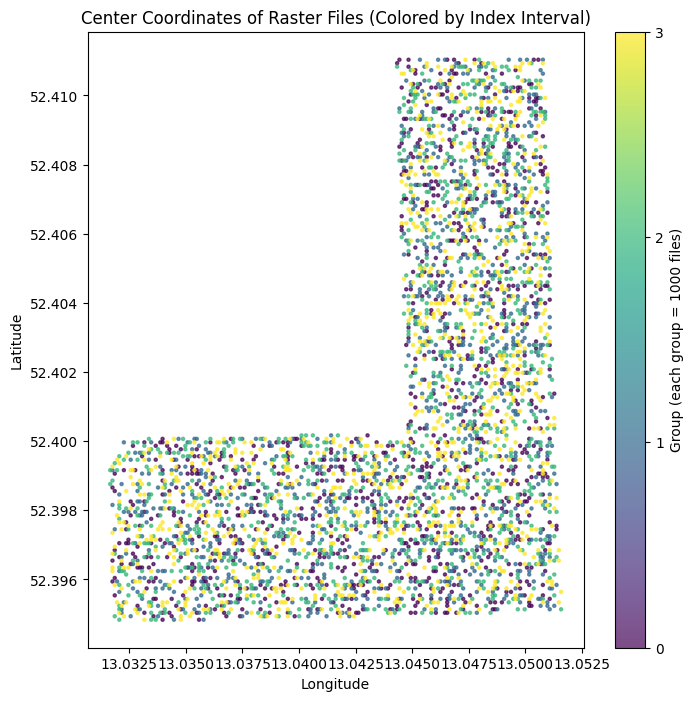

In [71]:
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.transform import xy
import numpy as np

# List of your raster file paths (replace with your actual list of 5000 files)
raster_files = selected_datapoints

lons = []
lats = []
groups = []  # This will hold group numbers based on index intervals

for i, file in enumerate(raster_files[:4000]):
    with rio.open(file) as dataset:
        width, height = dataset.width, dataset.height
        center_x = width // 2
        center_y = height // 2
        lon, lat = xy(dataset.transform, center_y, center_x)
        lons.append(lon)
        lats.append(lat)
        # Determine the group based on the file's index
        groups.append(i // 1000)  # Group 0: indices 0-999, Group 1: 1000-1999, etc.

# Convert lists to numpy arrays (optional, but useful)
lons = np.array(lons)
lats = np.array(lats)
groups = np.array(groups)

# Create the plot using a colormap. Here 'viridis' is used, but you can choose any colormap.
plt.figure(figsize=(8, 8))
scatter = plt.scatter(lons, lats, c=groups, cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Center Coordinates of Raster Files (Colored by Index Interval)')
# Add a colorbar to indicate the groups
cbar = plt.colorbar(scatter, ticks=range(groups.max()+1))
cbar.set_label('Group (each group = 1000 files)')
plt.show()

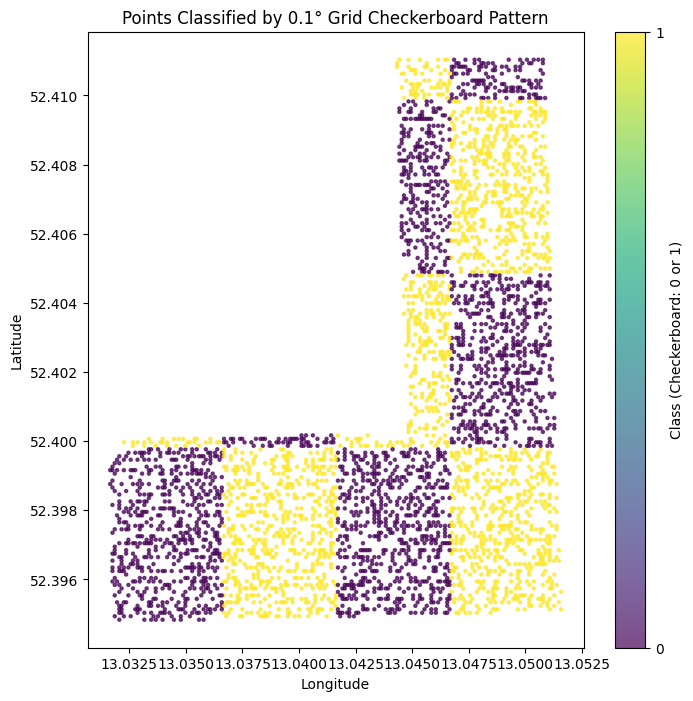

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.transform import xy

# Suppose you have a list of raster files (replace with your actual list)
raster_files = selected_datapoints[:4000]

lons = []
lats = []

# Extract center coordinates from each raster file
for file in raster_files:
    with rio.open(file) as dataset:
        width, height = dataset.width, dataset.height
        center_x = width // 2
        center_y = height // 2
        lon, lat = xy(dataset.transform, center_y, center_x)
        lons.append(lon)
        lats.append(lat)

# Convert to numpy arrays
lons = np.array(lons)
lats = np.array(lats)

# Determine the overall min and max (full range) for longitude and latitude
min_lon, max_lon = lons.min(), lons.max()
min_lat, max_lat = lats.min(), lats.max()

# For each point, compute which grid cell it falls into
# Each cell is 0.1 degrees on a side.
cell_x = np.floor((lons - min_lon) / 0.005).astype(int)
cell_y = np.floor((lats - min_lat) / 0.005).astype(int)

# Use a checkerboard pattern: assign class 0 if (cell_x + cell_y) is even, 1 if odd.
classes = (cell_x + cell_y) % 2

# Plot the points, colored by class
plt.figure(figsize=(8, 8))
scatter = plt.scatter(lons, lats, c=classes, cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Points Classified by 0.1° Grid Checkerboard Pattern')
# Optionally, add a colorbar that explains the two classes
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.set_label('Class (Checkerboard: 0 or 1)')
plt.show()


In [81]:
# Create masks for each class
group0_mask = (classes == 0)
group1_mask = (classes == 1)

# Split the file paths
group0_files = [raster_files[i] for i in range(len(raster_files)) if group0_mask[i]]
group1_files = [raster_files[i] for i in range(len(raster_files)) if group1_mask[i]]


In [84]:
from tqdm import tqdm
pbar = tqdm(total=4000)
with tf.io.TFRecordWriter(f"TFRecord_dir/TFRecord_val.tfrecord") as writer:
    for datapoint in group1_files:
        serialized_datapoint = serialize_datapoint(datapoint)
        writer.write(serialized_datapoint)
        pbar.update(1)
    
pbar.close()

 47%|████▋     | 1898/4000 [00:16<00:18, 112.52it/s]


In [89]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def build_shallow_unet(input_shape=(224, 224, 3), num_classes=6):
    # Define input
    inputs = Input(shape=input_shape)
    
    # Load a pretrained ResNet50, but we will only use the early layers.
    # include_top=False drops the classification head.
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable = False
    # Choose layers from the encoder as skip connections:
    # For example, use conv1_relu (112x112) and conv2_block3_out (56x56).
    skip1 = base_model.get_layer("conv1_relu").output          # (112, 112, 64)
    encoder_output = base_model.get_layer("conv2_block3_out").output  # (56, 56, 128)
    
    # ---- Decoder ----
    # Upsample from 56x56 to 112x112
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(encoder_output)
    # Concatenate with skip connection from conv1_relu
    x = Concatenate()([x, skip1])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    # Upsample from 112x112 to 224x224 (final resolution)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Final segmentation layer: use 1x1 conv to map to the desired number of classes.
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Build and summarize the model
model = build_shallow_unet(input_shape=(224, 224, 3), num_classes=6)
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 478,982 (1.83 MB)

 Trainable params: 249,222 (973.52 KB)

 Non-trainable params: 229,760 (897.50 KB)

In [91]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

def build_deep_unet(input_shape=(224, 224, 3), num_classes=6):
    # Define the input
    inputs = Input(shape=input_shape)
    
    # Create the ResNet50 backbone with pretrained ImageNet weights
    # include_top=False excludes the final dense layers.
    backbone = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in backbone.layers:
        layer.trainable = False
    # Extract feature maps for skip connections.
    # You can choose these layers based on the architecture.
    # For example, here are some common choices:
    skip1 = backbone.get_layer("conv1_relu").output       # Size: 112x112
    skip2 = backbone.get_layer("conv2_block3_out").output   # Size: 56x56
    skip3 = backbone.get_layer("conv3_block4_out").output   # Size: 28x28
    skip4 = backbone.get_layer("conv4_block6_out").output   # Size: 14x14

    # The deepest feature map from the backbone.
    encoder_output = backbone.get_layer("conv5_block3_out").output  # Size: 7x7

    # ---- Decoder ----
    # Block 1: Upsample from 7x7 to 14x14, concatenate skip4.
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(encoder_output)
    x = Concatenate()([x, skip4])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Block 2: Upsample from 14x14 to 28x28, concatenate skip3.
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, skip3])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Block 3: Upsample from 28x28 to 56x56, concatenate skip2.
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, skip2])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Block 4: Upsample from 56x56 to 112x112, concatenate skip1.
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = Concatenate()([x, skip1])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Optional: Upsample again to get back to the original resolution.
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Final output layer
    # Here we use softmax activation for multi-class segmentation.
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build the model
model = build_deep_unet(input_shape=(224, 224, 3), num_classes=6)
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 43,966,470 (167.72 MB)

 Trainable params: 20,378,758 (77.74 MB)

 Non-trainable params: 23,587,712 (89.98 MB)